<a href="https://colab.research.google.com/github/seismosmsr/machine_learning/blob/main/revised_conditional_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN
**Author:** [Aron Boettcher](spectral.online)<br>
**Date created:** 2022/07/13<br>
**Last modified:** 2022/08/12<br>
**Description:** Training a GAN conditioned on landsat pixels to generate GEDI waveforms.

## Introduction

Generative Adversarial Networks (GANs) let us generate novel image data, video data,
or audio data from a random input. Typically, the random input is sampled
from a normal distribution, before going through a series of transformations that turn
it into something plausible (image, video, audio, etc.). This principal has been extended to sequence data in the form of stock prices, language models, and music. 

However, a simple [DCGAN](https://arxiv.org/abs/1511.06434) doesn't let us control
the appearance (e.g. class) of the samples we're generating. For instance,
with a GAN that generates MNIST handwritten digits, a simple DCGAN wouldn't let us
choose the class of digits we're generating.
To be able to control what we generate, we need to _condition_ the GAN output
on a semantic input, such as the class of an image. This principal of conditioning can be extended to non-categorical inputs as well. Any condition able to be represented as a vector can be used to create a set of conditions underwhich an expected representation might be considered reasonable.

In this example, we'll build a **Conditional GAN** that can generate full waveform lidar profiles conditioned on a time series of multispectral pixel values. We'll be using a time series vector of multi spectral output from the [Landsat 8](https://www.usgs.gov/landsat-missions/landsat-8) sensor to condition the generation of a full waveform lidar profile from the [GEDI sensor](https://gedi.umd.edu/instrument/instrument-overview/). Landsat 8 and the landsat time series of multispectral earth observations represent a continuous time series of observations from 1984 until the present time. While these observations were made with various mission instruments, harmonized time series have been made available and are openly accessable on [Google Earth Engine](https://earthengine.google.com/). For this exercise, we'll be using the [USGS Landsat 8 Level 2, Collection 2, Tier 1](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2) product. This is the atmospherically corrected surface reflectance and land surface temperature product, from which we'll be using the coastal blue, blue, green, red, near infrared, shortwave infrared bands 1 and 2, and the kelving band. This represents 8 spectral measurements at the time of sensing.  At the time of the compostion of this notebook, this is the prefered product, owing to the Landsat 8 sensor being the most up-to-date and current sensor with a time series product available at a reasonable concurrency with the more recent GEDI data. Since we'll be sampling a range of GEDI waveforms taken over a period of approximately 3 years, and we want to use a deep time series of spectral data for conditioning, its imporant that we have full and complete coverage over this time period. The GEDI data we'll be using for this exercise were accessed using this [utitlity developed by the Earthshot Forest team](https://github.com/earthshot-forest/forest-team-gedi-etl). GEDI is a full waveform spaceborne photon counting sensor mounted to the instrument arm of the ISS, and has been collecting measurements in a 600m swath since 2017. Level 2A data were accessed in January of 2022, and their full waveform profiles used to access all landsat 8 measurements from 400 days previous to and up to 400 days after a GEDI waveform was generated. The following GEDI script can be used to perform [this utility in Earth Engine](https://code.earthengine.google.com/?scriptPath=users%2Fseismosmsr%2FForest_Structure_GAN%3AExtract_Dixie_Points).


A model that can generate full waveform predictions from spectral data can serve various useful applications and overcome many of the limitations of the existing infrastructure for earth forest observation currently available. While the GEDI sensor is still operational, its original mission was scheduled a 3 year mission. Owing to its design constraints and the high priority for realestate on the instrument wing of the ISS, this sensor will eventually be decommissioned and as of yet, there is no plan to launch a stand alone sensor. Likewise, the GEDI mission is a relatively young mission. We currently have around 4 years of GEDI coverage across the globe. These data were taken under varying atmospheric and forest cover conditions; having a tool that allows us to align those conditions to a single capture date can be very powerful. GEDI also represents a global training dataset between 57.5 degrees latitude north and south. This is the most extensive and complete dataset taken with the same instrument and gives us the opprutnity to train regionally appropriate models in an appropriate framework. Having such a framework opens up addtional avenues for exploration such as downsampling of landsat pixels and predicting canopy structure, or extending these data to another higher resolution sensor suite like the Copernicus mission or the Planet Labs planetscope multi spectral product.

## Sources of data and processing steps


### Data access
Two sources of data were used in this project. Firstly, GEDI fullwaveform, level 2A data were accesssed in January 2022 over the footprint of the Dixie Fire in California.

[Insert map object here]


### Data augmentation
This region was selected as a part of a broader study into the relationship between wildfire severity and canopy structure. Landsat 8 Level 2, Collection 2, Tier 1 pixels at the foot print of each fullwave form profile were accessed for up to 400 days before and after the date where a full waveform profile was generated. The coastal blue, blue, green, red, near infrared, shortwave infrared bands 1 and 2, and the kelving band were collated along a time series vector (64 timestamps) to create a 512 long times series vector of spectral emasurements.
[Table of spectral values]

This time series of data aligned to each waveform footprint, and segmented (plus minus) to 64 flyovers (~1024 days,or 2.75 years). This process resulted in several hundred possible spectral sequences for each waveform. The distance in time from wave form origination was recored and annoted for each full waveform, spectral profile pair.

[Drawing of relationship between waveform and spectral sequnces]

### Data splits
Spectral and waveform vectors were post-processed in R, resulting in ~20 million spectral sequences for several hundred thousand unique waveforms. Sequences were divided into training and test pools based on waveform ID, to prevent the potential of autocorrelation in a generative framework by have identical waveforms in both training and test dataset. Owing to the large availablity of data, a 99:1 split of training to test data was made based on waveform ID. 

### Data management
These data were loaded into cloud stoarge and are downloaded as apart of running this notebook.

### Other data considerations
The extensiveness of reference data available for this exercise offers several oppurtunities not explored in this work. Here, we use the full dataset of spectral/ waveform combinations with no filtering based on cloud cover or waveform quality, or distance in time from waveform measurement. Likewise, no smoothing or interpolation by band was implemented. The goal of this exercise is to identify how well the system can overcome and predict waveforms in what effectively represents the 'worst' of potential conditions. Several data augmentations could be made at the processing phase which might improve these results. Firstly and most readily, data could be filtered down to the most recent spectral dataset associated with the collection date of a waveform. Another option would be to allign spectral sequences to a common annual date (spectral sequences always begin in spring or so). Pixels could be filtered and ommited by Percent clouds. Finally, data could be interpolated and smoothed using something like a loess smoothing function. While all of these are interesting options that are likely to improve the perfomrance of the model, the current exercise is to examine the utility of doing effectively nothing to improve the quality of the data. In a sense, we're trying to examine the utility of this framework under the worst possible conditions and so these additional data augmentation steps are not explored here.

## Modeling framework

Generative models are notorious for the dificulty in developing and modeling their training. In an effort to determine the effectiveness of this approach, a multi stage approach was used for model development to ensure component models at least had the potential to generate reasonable results. Prior to implementing a conditional generative framework, an recurrent neural networks (RNN)   implementation for the prediction of waveform from spectral data was developed. The goal behind this stage was to ensure that meaningfully decent predicitions could of waveform could be made from spectral data. Second, a generative approach  with no conditioning was used to ensure that waveforms could effectively be generated and discriminated. Finally, these approaches are unified in a conditional generative approach were spectral conditional data are married with either generated waveform or reference waveform data in a conditional generative framwork.

### RNN prediction of full waveforms from spectral time series data

Recurrent neural networks (RNN) have demonstrated extraordiniry utility in the prediction of sequnce data (cite this). As well, some of the most recent and most advanced machine learning frameworks are based on an RNN configuraton (cite this). Long term short memory (LSTM) units are a subclass of RNN and have have found their way into the prediction of sequnce data. These frameworks have been developed and implemented to predict a wide range of sequence data like stock prices, natural language, and music. Owing to these prior works, I decided to use a multiple LSTM framework to vet out how effectively this framework could predict waveform from time series spectral data.

I implemented a 3 unit LSTM with each subunit composed of dense layer, followed by a dropout layer, followed by an LSTM layer. Three of these subunits in a row compose the full RNN. Each epoch a sample of 500,000 samples of training data were taken, along with 2000 samples of test data; training and validation loss and accuracy were recored printed every epoch and once validation accuracy appeared to have stabilized, training was halted. A final sample of 20,000 samples of test data were used to construct validation statistics.

Part of the goal of this process was to ensure that at least individuall, the component parts of the conditional GAN would be effective. I explored a range of other network structures including fully connected models, convolutional models, and very deep networks. Withthese networks I did not implement the network or compute and test statistics, but rather, visualized the output on training data to see if it produced decent results. The central issue with these other frameworks was that nodes did not appear to have enough node-node correlation in the final layer, resulting in predictions that were jagged and did not have the between unit smoothness demonstrated by the LSTM framework. 

### Generative adversarial network

Prior to implementing a conditional GAN, I wanted to explore the question of if it was even possible to generate waveform like data. This also represents an oppurutnity to vet out modeling framework and identify a configuration for a discriminator model that should be suitable in a condional framework. Only data from the training dataset were used to develop the GAN framework. Models were evaluated based on a visual inspection of their generated results.



## Coding references
Following are the references used for developing this example (a full suite of reference is available at the end of this document as an appendix):

* [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)

* [Lecture on Conditional Generation from Coursera](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/conditional-generation-inputs-2OPrG)

If you need a refresher on GANs, you can refer to the "Generative adversarial networks"
section of
[this resource](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/r-3/232).


This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

## Imports

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

## Constants and hyperparameters

In [ ]:
batch_size = 256
num_channels = 1
num_classes = 101
image_size = 512
latent_dim = 512

## Loading the MNIST dataset and preprocessing it

In [ ]:
!pip install gdown
import gdown
import zipfile
import os

# I switched to pngs and jpgs to try and use tensorflows native vectorization
#todo: get gdal working so you can just use geotiff
url = 'https://drive.google.com/uc?id=1kwU_CkP1X5M1CDlYKPkb9p5J8GulWBXr'
output = 'sample_test.csv'

#Update with proper validation data
# https://drive.google.com/file/d/1unLB1XCJHoul3gqGYGzqSS8QMr5ZvJ9h/view?usp=sharing
gdown.download(url,output,quiet = False)

url = 'https://drive.google.com/uc?id=1graojPHaMvZGHmocsUFLds9bFWQG_mr6'
output = 'sample_train.csv'

#Update with proper validation data
# https://drive.google.com/file/d/1unLB1XCJHoul3gqGYGzqSS8QMr5ZvJ9h/view?usp=sharing
gdown.download(url,output,quiet = False)
# cwd = os.getcwd()
# with zipfile.ZipFile(cwd+'/sample.zip', 'r') as zip_ref:
#     zip_ref.extractall(cwd+'/sample')

# PATH = os.path.join(os.path.dirname(cwd+'/sample/'), 'sample/')
# print(PATH)

Downloading...
From: https://drive.google.com/uc?id=1kwU_CkP1X5M1CDlYKPkb9p5J8GulWBXr
To: /content/sample_test.csv
100%|██████████| 137M/137M [00:00<00:00, 147MB/s]
Downloading...
From: https://drive.google.com/uc?id=1graojPHaMvZGHmocsUFLds9bFWQG_mr6
To: /content/sample_train.csv
100%|██████████| 13.8G/13.8G [01:01<00:00, 222MB/s]


'sample_train.csv'

In [ ]:
# generate n real samples with class labels
def generate_real_samples(s,filename = '/content/sample.csv'):
  import random
  import pandas
  import numpy
	# Sample s rows of data.frame

  #number of records in file (excludes header)
  n = sum(1 for line in open(filename)) - 1 

  #the 0-indexed header will not be included in the skip list
  skip = sorted(random.sample(range(1,n+1),n-s)) 
  df = pandas.read_csv(filename, skiprows=skip)
  X = []
  for i in range(len(df.index)):
    text_exa = df['rh'][i]
    text_exa = str(text_exa).replace("{","").replace("}", "")
    test_exa = text_exa.split(",")
    test_exa = [float(i) for i in test_exa]
    # test_exa = test_exa
    X.append(test_exa)


	# generate class labels
  y = []
  for i in range(len(df.index)):
    # y_one = numpy.ones(1)
    y_one = df['ls'][i]
    y_one = str(y_one).replace("{","").replace("}", "")
    y_one = y_one.split(",")
    y_one = [float(i) for i in y_one]
    y.append(y_one)

    
  X = numpy.array(X)
  y = numpy.array(y)

  # X = (X.astype("float32") / 65455.0).astype("float32")
  # y =(y.astype("float32")+100)/255
  X = (((X.astype("float32")+100)/255)).astype("float32")
  y =(y.astype("float32")/ 65455.0).astype("float32")
  return X, y

In [ ]:
# generate_real_samples(2)

In [ ]:
import numpy as np
import tensorflow as tf

# We'll use all the available examples from both the training and test
# sets.
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
(x_train, y_train) = generate_real_samples(450000,filename = '/content/sample_train.csv')
(x_test, y_test) = generate_real_samples(2000,filename = '/content/sample_test.csv')

# all_pixels = x_train
# all_labels = np.concatenate([y_train, y_test])

# # Scale based on reflectence values:
# # https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=en#bands
# x_train = (x_train.astype("float32") / 65455.0).astype("float32")
# all_labels =(y_train.astype("float32")+100)/255

# x_test = (x_test.astype("float32") / 65455.0).astype("float32")
# y_test =(y_test.astype("float32")+100)/255
# # Create tf.data.Dataset.
dataset_train = tf.data.Dataset.from_tensor_slices((y_train,x_train))
dataset_train = dataset_train.shuffle(buffer_size=1024).batch(batch_size)

dataset_test = tf.data.Dataset.from_tensor_slices((y_test,x_test))
dataset_test = dataset_test.shuffle(buffer_size=1024).batch(batch_size)

# print(f"Shape of training images: {all_labels[1]}")
# print(f"Shape of training images: {all_pixels.shape}")
# print(f"Shape of training labels: {all_labels.shape}")

In [ ]:
# print(x_train[1])

## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [ ]:
generator_in_channels = latent_dim + image_size
discriminator_in_channels = image_size + num_classes
print(generator_in_channels, discriminator_in_channels)

1024 613


## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

In [ ]:
from tensorflow.python.ops.gen_math_ops import sigmoid
from keras import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Concatenate
from keras import Model

# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((discriminator_in_channels,)),
     
        layers.Dense(1024, activation='relu'),
        layers.Reshape(target_shape=(2,512)),
        layers.Dropout(.25),
        layers.LSTM(32, activation="relu",return_sequences=True),
     
        layers.Dense(512, activation='relu'),
        layers.Reshape(target_shape=(2,512)),
        layers.Dropout(.25),
        layers.LSTM(32, activation="relu",return_sequences=True),
     
        layers.Dense(512, activation='relu'),
        layers.Reshape(target_shape=(2,512)),
        layers.Dropout(.25),
        layers.LSTM(32, activation="relu",return_sequences=True),
     
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
     
        layers.Dense(1),
    ],
    name="discriminator",)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
     
        layers.Dense(1024, activation='relu'),
        layers.Reshape(target_shape=(2,512)),
        layers.Dropout(.25),
        layers.LSTM(32, activation="relu",return_sequences=True),
     
        layers.Dense(512, activation='relu'),
        layers.Reshape(target_shape=(2,512)),
        layers.Dropout(.25),
        layers.LSTM(32, activation="relu",return_sequences=True),
     
        layers.Dense(512, activation='relu'),
        layers.Reshape(target_shape=(2,512)),
        layers.Dropout(.25),
        layers.LSTM(32, activation="relu",return_sequences=True),
     
        layers.Flatten(),
        layers.Dense(512, activation='relu'),

        # layers.Dense(num_classes),
        layers.Dense(num_classes,  activation="linear"),
    ],
    name="generator",)

## Creating a `ConditionalGAN` model

In [ ]:

class ConditionalGAN(keras.Model):
  
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        # Create the discriminator.
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_pixels, real_labels = data
        # print(real_pixels[0])
        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_pixels)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # print(random_latent_vectors[0])
        random_vector_pixels = tf.concat(
            [random_latent_vectors, real_pixels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_labels = self.generator(random_vector_pixels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_pixel_and_labels = tf.concat([generated_labels, real_pixels], -1)
        real_pixel_and_labels = tf.concat([real_labels, real_pixels], -1)
        combined_images = tf.concat(
            [real_pixel_and_labels,fake_pixel_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.zeros((batch_size, 1)),tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, real_pixels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_labels = self.generator(random_vector_labels)
            fake_pixels_and_labels = tf.concat([real_pixels, fake_labels], -1)
            predictions = self.discriminator(fake_pixels_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Training the Conditional GAN

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

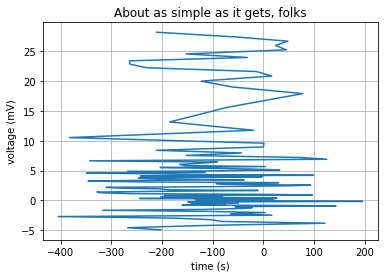

In [ ]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator
(real_labels, real_pixels) = generate_real_samples(batch_size,filename = '/content/sample_test.csv')

random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
# print(random_latent_vectors[0])
random_vector_pixels = tf.concat(
    [random_latent_vectors, real_pixels], axis=1
)
# print(real_labels[1])

generated_waveform = trained_gen(random_vector_pixels)

# print(generated_waveform[1])
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(generated_waveform[1], real_labels[1])

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

# fig.savefig("test.png")
plt.show()

In [ ]:
for i in range(1):
  # (x_train, y_train) = generate_real_samples(250000,filename = '/content/sample_train.csv')
  # (x_test, y_test) = generate_real_samples(20000,filename = '/content/sample_test.csv')
  # dataset_train = tf.data.Dataset.from_tensor_slices((y_train,x_train))
  # dataset_train = dataset_train.shuffle(buffer_size=1024).batch(batch_size)

  # dataset_test = tf.data.Dataset.from_tensor_slices((y_test,x_test))
  # dataset_test = dataset_test.shuffle(buffer_size=1024).batch(batch_size)
  
  
  cond_gan.fit(dataset_train, epochs=10)


Epoch 1/10
977/977 [==============================] - 37s 38ms/step - g_loss: 2.4040e-10 - d_loss: 5.2266e-13
Epoch 2/10
977/977 [==============================] - 36s 37ms/step - g_loss: 1.9956e-10 - d_loss: 5.2186e-13
Epoch 3/10
977/977 [==============================] - 36s 37ms/step - g_loss: 1.6315e-10 - d_loss: 5.2282e-13
Epoch 4/10
977/977 [==============================] - 37s 38ms/step - g_loss: 1.3238e-10 - d_loss: 5.2417e-13
Epoch 5/10
977/977 [==============================] - 37s 38ms/step - g_loss: 1.2048e-10 - d_loss: 5.2348e-13
Epoch 6/10
977/977 [==============================] - 36s 37ms/step - g_loss: 9.6769e-11 - d_loss: 5.2303e-13
Epoch 7/10
977/977 [==============================] - 36s 37ms/step - g_loss: 8.3790e-11 - d_loss: 5.2158e-13
Epoch 8/10
977/977 [==============================] - 36s 37ms/step - g_loss: 7.2140e-11 - d_loss: 5.1989e-13
Epoch 9/10
977/977 [==============================] - 36s 37ms/step - g_loss: 6.1105e-11 - d_loss: 5.2061e-13
Epoch 10/1

## Interpolating between classes with the trained generator

In [ ]:
from keras import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Concatenate
from keras import Model

input_layer = Input(shape=(512))

dense1 = Dense(1024, activation='relu')(input_layer)
resh1 = Reshape(target_shape=(2,512))(dense1)
dropout1 =  Dropout(.25)(resh1)
lstm1 = LSTM(32, activation="relu",return_sequences=True)(dropout1)
# flat1 = Flatten()(lstm1)
# flat2 = Flatten()(resh1)
# conc1 = Concatenate(axis=1)([flat1,flat2])

dense2 = Dense(512, activation='relu')(lstm1)
resh2 = Reshape(target_shape=(2,512))(dense2)
dropout2 =  Dropout(.25)(resh2)
lstm2 = LSTM(32, activation="relu",return_sequences=True)(dropout2)
# flat3 = Flatten()(lstm2)
# flat4 = Flatten()(resh2)
# conc2 = Concatenate(axis=1)([flat3,flat4])

dense3 = Dense(512, activation='relu')(lstm2)
resh3 = Reshape(target_shape=(2,512))(dense3)
dropout3 =  Dropout(.25)(resh3)
lstm3 = LSTM(32, activation="relu",return_sequences=True)(dropout3)
# flat5 = Flatten()(lstm3)
# flat6 = Flatten()(resh3)
# conc3 = Concatenate(axis=1)([flat5,flat6])
dense4 = Dense(512, activation='relu')(lstm3)
flat6 = Flatten()(dense4)

dense4 = Dense(1024, activation='relu')(flat6)

output_layer = Dense(101, activation='linear')(dense4)
model = Model(inputs=input_layer, outputs=output_layer)
optz = keras.optimizers.Adam(lr=0.0001)
model.compile(loss="MeanSquaredError", optimizer=optz,metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# from keras import Input
# from keras.layers import Conv1D
# from keras.layers import MaxPooling1D
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import Reshape
# from keras.layers import Dropout

# from keras import Model
# input_layer = Input(shape=(512))
# dense1 = Dense(1024, activation='relu')(input_layer)
# dense2 = Dense(1024, activation='relu')(dense1)
# dropout1 =  Dropout(.25)(dense2)
# resh1 = Reshape(target_shape=(1,16,64))(dropout1)
# conv1 = Conv1D(filters=32,
#                kernel_size=16,
#                strides=1,
#                activation='relu')(resh1)
# resh1 = Reshape(target_shape=(32,1))(conv1)
# pool1 = MaxPooling1D(pool_size=2)(resh1)
# lstm1 = LSTM(32, activation="relu")(pool1)
# output_layer = Dense(101, activation='linear')(lstm1)
# model = Model(inputs=input_layer, outputs=output_layer)
# optimizer = keras.optimizers.Adam(lr=0.0001)
# model.compile(loss="MeanSquaredError", optimizer=optimizer,metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_19 (Dense)            (None, 1024)              525312    
                                                                 
 reshape_11 (Reshape)        (None, 2, 512)            0         
                                                                 
 dropout_10 (Dropout)        (None, 2, 512)            0         
                                                                 
 lstm_10 (LSTM)              (None, 2, 32)             69760     
                                                                 
 dense_20 (Dense)            (None, 2, 512)            16896     
                                                                 
 reshape_12 (Reshape)        (None, 2, 512)            0   

In [ ]:
for i in range(3):
  (x_train, y_train) = generate_real_samples(500000,filename = '/content/sample_train.csv')
  (x_test, y_test) = generate_real_samples(20000,filename = '/content/sample_test.csv')


  dataset_train = tf.data.Dataset.from_tensor_slices((y_train,x_train))
  dataset_train = dataset_train.shuffle(buffer_size=1024).batch(batch_size)

  dataset_test = tf.data.Dataset.from_tensor_slices((y_test,x_test))
  dataset_test = dataset_test.shuffle(buffer_size=1024).batch(batch_size)

  model.fit(dataset_train,validation_data =dataset_test , epochs=10)

Epoch 1/10
1954/1954 [==============================] - 48s 22ms/step - loss: 23.9445 - accuracy: 0.9993 - val_loss: 19.1184 - val_accuracy: 1.0000
Epoch 2/10
1954/1954 [==============================] - 43s 22ms/step - loss: 19.4756 - accuracy: 1.0000 - val_loss: 18.5930 - val_accuracy: 1.0000
Epoch 3/10
1954/1954 [==============================] - 44s 23ms/step - loss: 18.7894 - accuracy: 1.0000 - val_loss: 18.3254 - val_accuracy: 1.0000
Epoch 4/10
1954/1954 [==============================] - 44s 23ms/step - loss: 18.3731 - accuracy: 1.0000 - val_loss: 17.9789 - val_accuracy: 1.0000
Epoch 5/10
1954/1954 [==============================] - 43s 22ms/step - loss: 18.1695 - accuracy: 1.0000 - val_loss: 17.8230 - val_accuracy: 1.0000
Epoch 6/10
1954/1954 [==============================] - 41s 21ms/step - loss: 17.9754 - accuracy: 1.0000 - val_loss: 17.6393 - val_accuracy: 1.0000
Epoch 7/10
  92/1954 [>.............................] - ETA: 37s - loss: 17.5012 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [ ]:
# # import numpy as np
# # import tensorflow as tf

# (x_train, y_train) = generate_real_samples(300000,filename = '/content/sample_train.csv')
# (x_test, y_test) = generate_real_samples(2000,filename = '/content/sample_test.csv')


# dataset_train = tf.data.Dataset.from_tensor_slices((y_train,x_train))
# dataset_train = dataset_train.shuffle(buffer_size=1024).batch(batch_size)

# dataset_test = tf.data.Dataset.from_tensor_slices((y_test,x_test))
# dataset_test = dataset_test.shuffle(buffer_size=1024).batch(batch_size)


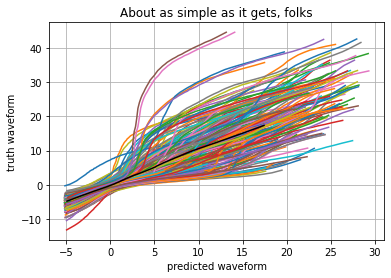

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

(real_labels, real_pixels) = generate_real_samples(batch_size,filename = '/content/sample_test.csv')
p_test = model.predict(real_pixels)


err_vec = (p_test-real_labels)

mean_err_vec = (np.mean(err_vec,axis=0))
mean_label_vec = (np.mean(real_labels,axis=0))
mean_pred_vec = (np.mean(p_test,axis=0))
fig, ax = plt.subplots()
m = 21
for i in range(batch_size):
  ax.plot(p_test[i],real_labels[i],label=i)

# ax.plot(mean_label_vec,mean_err_vec,color='black')
ax.plot(mean_pred_vec,mean_label_vec,color='black')
# plt.plot([-0.02, 0.07], [-0.02, 0.07], 'k-', lw=2)
ax.set(xlabel='predicted waveform', ylabel='truth waveform',
       title='About as simple as it gets, folks')
ax.grid()

# fig.savefig("test.png")
plt.show()
# print(np.mean(np.mean(p_test,axis=1)))

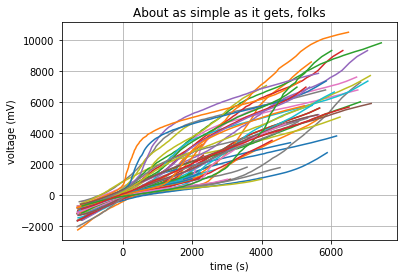

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
m = 21
for i in range(64):
  ax.plot(p_test[i]*255, real_labels[i]*255,label=i)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

# fig.savefig("test.png")
plt.show()

In [ ]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator
(real_labels, real_pixels) = generate_real_samples(batch_size,filename = '/content/sample_test.csv')

# batch_size = tf.shape(real_pixels)[0]
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
# print(random_latent_vectors[0])
random_vector_pixels = tf.concat(
    [random_latent_vectors, real_pixels], axis=1
)
# print(real_labels[1])

generated_waveform = trained_gen(random_vector_pixels)

# print(generated_waveform[1])
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(generated_waveform[1], real_labels[1])

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

# fig.savefig("test.png")
plt.show()

Here, we first sample noise from a normal distribution and then we repeat that for
`num_interpolation` times and reshape the result accordingly.
We then distribute it uniformly for `num_interpolation`
with the label indentities being present in some proportion.

In [ ]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")

We can further improve the performance of this model with recipes like
[WGAN-GP](https://keras.io/examples/generative/wgan_gp).
Conditional generation is also widely used in many modern image generation architectures like
[VQ-GANs](https://arxiv.org/abs/2012.09841), [DALL-E](https://openai.com/blog/dall-e/),
etc.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conditional-gan) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conditional-GAN).

In [ ]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import random

In [ ]:
        # layers.Dense(1024, activation='relu'),
        # layers.Reshape(target_shape=(2,512)),
        # layers.Dropout(.25),
        # layers.LSTM(32, activation="relu",return_sequences=True),
     
        # layers.Dense(512, activation='relu'),
        # layers.Reshape(target_shape=(2,512)),
        # layers.Dropout(.25),
        # layers.LSTM(32, activation="relu",return_sequences=True),
     
        # layers.Dense(512, activation='relu'),
        # layers.Reshape(target_shape=(2,512)),
        # layers.Dropout(.25),
        # layers.LSTM(32, activation="relu",return_sequences=True),
     
        # layers.Flatten(),
        # layers.Dense(512, activation='relu'),

In [ ]:
# define the standalone discriminator model
def define_discriminator(latent_dim=512,n_inputs=101):
	model = Sequential()
	model.add(Dense(1000, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs+latent_dim))
	model.add(Dense(1, activation='sigmoid'))
 
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim=512, n_outputs=101):
  model = Sequential()

  model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim+latent_dim))

  # model.add(Reshape(target_shape = (2,512)))
  # model.add(Dropout(0.25))
  # model.add(LSTM(512,activation = "relu",return_sequences = True))
  # model.add(Dense(512, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))

  # model.add(Flatten())

  model.add(Dense(n_outputs, activation='linear'))
  return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
  # make weights in the discriminator not trainable
  discriminator.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(generator)
  # add the discriminator

  # inp = Input((generator,))

  # discriminator_condition = Model(discriminator,inp)

  model.add(discriminator)
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

In [ ]:
# generate n real samples with class labels
def generate_real_samples_2(real_labels,real_pixels):
  # X = real_labels[random.sample(range(len(real_labels)), n)]
  X = tf.concat([real_labels, real_pixels], axis=1)
  # X = real_labels
  y = ones((len(real_labels), 1))
  return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim,real_pixels):
  # generate points in the latent space
  rand_input = randn(latent_dim * len(real_pixels))
  # reshape into a batch of inputs for the network
  rand_input = rand_input.reshape(len(real_pixels), latent_dim)

  random_vector_pixels = tf.concat([rand_input, real_pixels], axis=1)
  # x_input = real_pixels[random.sample(range(len(real_pixels)), n)]
  return random_vector_pixels

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, real_pixels):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, real_pixels)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((len(real_pixels), 1))
	return X, y

In [ ]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=25):
  n_sample = random.sample(range(len(real_pixels_sample)), n)

  # prepare real samples
  x_real, y_real = generate_real_samples_2(real_labels_sample[n_sample],real_pixels_sample[n_sample])

  # evaluate discriminator on real examples
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)

  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, real_pixels_sample[n_sample])

  # evaluate discriminator on fake examples
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
  fig, ax = plt.subplots()
  for i in range(n):
    ax.plot(x_real[i],range(101),color='blue')
    ax.plot(x_fake[i],range(101),color='red')
  # ax.plot(mean_label_vec,mean_err_vec,color='black')
  # ax.plot(mean_pred_vec,mean_label_vec,color='black')
  # plt.plot([-0.02, 0.07], [-0.02, 0.07], 'k-', lw=2)
  ax.set(xlabel='waveform (red = generated sample; blue = truth sample', ylabel='percentile',
      title='About as simple as it gets, folks')
  ax.grid()
  plt.show()

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=1000, n_eval=300):
	# determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)
  n_sample = random.sample(range(len(real_pixels_sample)), half_batch)

  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples_2(real_labels_sample[n_sample], real_pixels_sample[n_sample])

    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, real_pixels_sample[n_sample])

    # update discriminator
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)

    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, real_pixels_sample[n_sample])

    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))

    # update the generator via the discriminator's error
    gan_model.train_on_batch(x_gan, y_gan)

    # evaluate the model every n_eval epochs
    if (i+1) % n_eval == 0:
      summarize_performance(i, g_model, d_model, latent_dim)

In [ ]:
# (real_labels_sample, real_pixels_sample) = generate_real_samples(200000,filename = '/content/sample_train.csv')
# size of the latent space
latent_dim = 512
# create the discriminator
discriminator = define_discriminator()

# discriminator.summary()
# create the generator
generator = define_generator(latent_dim)

# print(generator.input)
# generator.summary()
# create the gan
gan_model = define_gan(generator, discriminator)

# train model
train(generator, discriminator, gan_model, latent_dim)

KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name='dense_369_input'), name='dense_369_input', description="created by layer 'dense_369_input'")


ValueError: ignored

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU, Activation, Input, Dense, Dropout, Concatenate, BatchNormalization
from keras.models import Model
from keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist

In [ ]:
def build_gan(generator, discriminator, name="gan"):
    '''Build the GAN from a generator and a discriminator'''
    yfake = Activation("linear", name="yfake")(discriminator(generator(generator.inputs)))
    yreal = Activation("linear", name="yreal")(discriminator(discriminator.inputs))
    model = Model(generator.inputs + discriminator.inputs, [yfake, yreal], name=name)
    return model
    

In [ ]:
def disc(image_dim, label_dim, layer_dim=1024, reg=lambda: l1_l2(1e-5, 1e-5)):
    '''Discriminator network'''
    x      = (Input(shape=(image_dim,), name='discriminator_input'))
    label  = (Input(shape=(label_dim,), name='discriminator_label'))
    inputs = (Concatenate(name='input_concatenation'))([x, label])
    a = (Dense(layer_dim, name="discriminator_h1", kernel_regularizer=reg()))(inputs)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(int(layer_dim / 2), name="discriminator_h2", kernel_regularizer=reg()))(a)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(int(layer_dim / 4), name="discriminator_h3", kernel_regularizer=reg()))(a)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(1, name="discriminator_y", kernel_regularizer=reg()))(a)
    a = (Activation('sigmoid'))(a)
    model = Model(inputs=[x, label], outputs=a, name="discriminator")
    return model

In [ ]:
def gen(noise_dim, label_dim, image_dim, layer_dim=1024, activ='tanh', reg=lambda: l1_l2(1e-5, 1e-5)):
    '''Generator network'''
    z      = (Input(shape=(noise_dim,), name='generator_input'))
    label  = (Input(shape=(label_dim,), name='generator_label'))
    inputs = (Concatenate(name='input_concatenation'))([z, label])
    a = (Dense(int(layer_dim / 4), name="generator_h1", kernel_regularizer=reg()))(inputs)
    a = (LeakyReLU(0.2))(a)    # Trick 5
    a = (Dense(int(layer_dim / 2), name="generator_h2", kernel_regularizer=reg()))(a)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(layer_dim, name="generator_h3", kernel_regularizer=reg()))(a)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(np.prod(image_dim), name="generator_x_flat", kernel_regularizer=reg()))(a)
    a = (Activation(activ))(a)    
    model = Model(inputs=[z, label], outputs=[a, label], name="generator")
    return model

In [ ]:
def gen(noise_dim, label_dim, image_dim, layer_dim=1024, activ='tanh', reg=lambda: l1_l2(1e-5, 1e-5)):
    '''Generator network'''
    z      = (Input(shape=(noise_dim,), name='generator_input'))
    label  = (Input(shape=(label_dim,), name='generator_label'))
    inputs = (Concatenate(name='input_concatenation'))([z, label])
    a = (Dense(int(layer_dim / 4), name="generator_h1", kernel_regularizer=reg()))(inputs)
    a = (LeakyReLU(0.2))(a)    # Trick 5
    a = (Dense(int(layer_dim / 2), name="generator_h2", kernel_regularizer=reg()))(a)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(layer_dim, name="generator_h3", kernel_regularizer=reg()))(a)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(np.prod(image_dim), name="generator_x_flat", kernel_regularizer=reg()))(a)
    a = (Activation(activ))(a)    
    model = Model(inputs=[z, label], outputs=[a, label], name="generator")
    return model

In [ ]:
def make_trainable(net, val):
    '''Changes the trainable property of a model as a whole and layer by layer'''
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [ ]:
# ------------------------------------------------------------------------------
# Data preparation
# ------------------------------------------------------------------------------
# (x_train, l_train), (x_test, l_test) = mnist.load_data()
# x_train = np.concatenate((x_train, x_test))
# l_train = np.concatenate((l_train, l_test))

# # Normalization according to Trick 1
# x_train = x_train.reshape(x_train.shape[0], 784)
# x_train = (x_train - 127.5) / 127.5
# l_train = to_categorical(l_train)

In [ ]:
(real_labels_sample, real_pixels_sample) = generate_real_samples(200000,filename = '/content/sample_train.csv')

In [ ]:
# real_pixels_sample[0]

In [ ]:
# x_train = real_pixels_sample
# l_train = real_labels_sample

l_train = real_pixels_sample
x_train = real_labels_sample

In [ ]:
x_train[0]

array([0.35894117, 0.36172548, 0.36392158, 0.36580393, 0.36756864,
       0.36890197, 0.37019607, 0.3712157 , 0.37227452, 0.37313727,
       0.374     , 0.37490195, 0.37560785, 0.3761961 , 0.37694117,
       0.3775294 , 0.37811765, 0.3787059 , 0.37929413, 0.37988237,
       0.38031372, 0.38074508, 0.38133332, 0.3817647 , 0.3822353 ,
       0.38266668, 0.38309804, 0.38352942, 0.3839608 , 0.38443136,
       0.38470587, 0.38513726, 0.38556862, 0.38603923, 0.38631374,
       0.3867451 , 0.38705882, 0.38749018, 0.3877647 , 0.3882353 ,
       0.3885098 , 0.38894117, 0.3892549 , 0.3895294 , 0.3899608 ,
       0.3902745 , 0.390549  , 0.3910196 , 0.39129412, 0.39160785,
       0.3920392 , 0.3922745 , 0.39258823, 0.39301962, 0.39329413,
       0.39360785, 0.39403924, 0.39435294, 0.39462745, 0.3950588 ,
       0.39537254, 0.39580393, 0.39607844, 0.39654902, 0.39682353,
       0.3972549 , 0.3976863 , 0.398     , 0.39843136, 0.39886275,
       0.39933333, 0.39976472, 0.4001961 , 0.40062746, 0.40105

In [ ]:
# ------------------------------------------------------------------------------
# Parameter choice
# ------------------------------------------------------------------------------    
# Dimension of noise to be fed to the generator
noise_dim = 512
# Dimension of images generated
image_dim = 101
# Dimension of labels
label_dim = 512

batch_size  = 20000
num_batches = int(x_train.shape[0] / batch_size)
num_epochs  = 100

In [ ]:
# ------------------------------------------------------------------------------
# Network creation
# ------------------------------------------------------------------------------
# Create generator ((z, l) -> (x, l))
generator = gen(noise_dim, label_dim, image_dim)
adam = Adam(lr=0.0002, beta_1=0.5)
generator.compile(loss='linear', optimizer=adam)    # Trick 9

# Create discriminator ((x, l) -> y)
discriminator = disc(image_dim, label_dim)
discriminator.compile(loss='binary_crossentropy', optimizer='SGD')    # Trick 9

# Build GAN. Note how the discriminator is set to be not trainable since the beginning
make_trainable(discriminator, False)
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=adam)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


https://gist.github.com/apozas/38d4640d9e6525b43db62dac846f1c19

In [ ]:
# ------------------------------------------------------------------------------
# Training
# ------------------------------------------------------------------------------
for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    for index in range(num_batches):
        # Train the discriminator. It looks like training works best if it is trained first on only real data, and then only
        # on fake data, so let's do that. This is Trick 4.
        make_trainable(discriminator, True)
        # Train dicriminator on real data
        batch       = np.random.randint(0, x_train.shape[0], size=batch_size)
        image_batch = x_train[batch]
        label_batch = l_train[batch]
        y_real      = np.ones(batch_size) + 0.2 * np.random.uniform(-1, 1, size=batch_size)    # Label smoothing. Trick 6
        discriminator.train_on_batch([image_batch, label_batch], y_real)
        # Train the discriminator on fake data
        noise_batch      = np.random.normal(0, 1, (batch_size, noise_dim))    # Trick 3
        generated_images = generator.predict([noise_batch, label_batch])
        y_fake           = np.zeros(batch_size) + 0.2 * np.random.uniform(0, 1, size=batch_size)    # Label smoothing
        d_loss = discriminator.train_on_batch(generated_images, y_fake)
        
        # Recall that generated_images already contains the labels
        # Train the generator. We train it through the whole model. There is a very subtle point here. We want to minimize the error
        # of the discriminator, but on the other hand we want to have the generator maximizing the loss of the discriminator (make him
        # not capable of distinguishing which images are real). One way to achieve this is to change the loss function of the generator
        # by some kind of "negative loss", which in practice is implemented by switching the labels of the real and the fake
        # images. Note that when training the discriminator we were doing the assignment real_image->1, fake_image->0, so now
        # we will do real_image->0, fake_image->1. The order of the outputs is [fake, real], as given by build_gan(). This is Trick 2.
        
        make_trainable(discriminator, False)
        gan_loss = gan.train_on_batch([noise_batch, label_batch, image_batch, label_batch], [y_real, y_fake])

    print(
        "Batch {}/{}: Discriminator loss = {}, GAN loss = {}".format(index + 1, num_batches, d_loss,
                                                                      gan_loss))
# Save weights. Just saving the whole GAN should work as well
generator.save_weights('generator_cGAN.h5')
discriminator.save_weights('discriminator_cGAN.h5')
gan.save_weights('gan_cGAN.h5')


Epoch 1/100
Batch 10/10: Discriminator loss = 1.2220244407653809, GAN loss = [2.142899513244629, 0.6300979256629944, 0.7511997222900391]
Epoch 2/100
Batch 10/10: Discriminator loss = 1.221388339996338, GAN loss = [2.1390552520751953, 0.627986490726471, 0.7524259686470032]
Epoch 3/100
Batch 10/10: Discriminator loss = 1.220507264137268, GAN loss = [2.1349000930786133, 0.6264059543609619, 0.7528268694877625]
Epoch 4/100
Batch 10/10: Discriminator loss = 1.2189817428588867, GAN loss = [2.131662368774414, 0.626137375831604, 0.7528547048568726]
Epoch 5/100
Batch 10/10: Discriminator loss = 1.2178642749786377, GAN loss = [2.128270149230957, 0.6252326369285583, 0.7533897757530212]
Epoch 6/100
Batch 10/10: Discriminator loss = 1.2172073125839233, GAN loss = [2.1247072219848633, 0.6235069632530212, 0.7545945048332214]
Epoch 7/100
Batch 10/10: Discriminator loss = 1.216864824295044, GAN loss = [2.1214215755462646, 0.6220585703849792, 0.7558053731918335]
Epoch 8/100
Batch 10/10: Discriminator los

In [ ]:
batch       = range(10)
image_batch = x_train[batch]
label_batch = l_train[batch]
# print(image_batch)
y_real      = np.ones(10) + 0.2 * np.random.uniform(-1, 1, size=10)    # Label smoothing. Trick 6
# discriminator.train_on_batch([image_batch, label_batch], y_real)
# Train the discriminator on fake data
noise_batch      = np.random.normal(0, 1, (10, noise_dim))    # Trick 3
generated_images = generator.predict([noise_batch, label_batch])

In [ ]:
# generated_images[0][1]

In [ ]:
# generated_images[0][0]

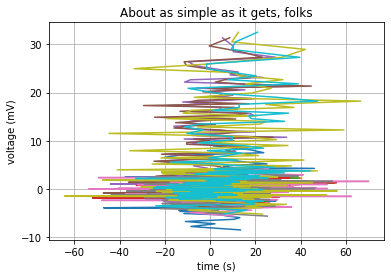

In [ ]:
# ------------------------------------------------------------------------------
# Plotting
# ------------------------------------------------------------------------------
# plt.figure(figsize=(20, 2))
# # print(label_dim)
# for i in range(len(generated_images[0])):
#     im =generated_images[0][i].reshape(28,28)
#     plt.subplot(1, label_dim, i+1)
#     plt.axis('off')
#     plt.imshow(im, cmap='Greys_r')
# plt.show()


fig, ax = plt.subplots()
# m = 21
for i in range(len(generated_images[0])):
  ax.plot(generated_images[0][i]*255-100, image_batch[i]*255-100,label=i)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

# fig.savefig("test.png")
plt.show()